In [14]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

# from scipy.optimize import differential_evolution
# from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

In [15]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso  = 'SM2RAIN', '1dy'
# product, time_reso = 'CHIRPS', '1dy'

yy_s, yy_e = 2002, 2012

years_num = yy_e - yy_s + 1
full_years = np.arange(yy_s, yy_e + 1)

# # Coast area 
# lon_min, lon_max, lat_min, lat_max, area, toll = 12, 12.5, 45.2, 45.7, 'COAST', 0.05
# # Fast area
# lon_min, lon_max, lat_min, lat_max, area, toll = 11.5, 12, 45.5, 46, 'FAST', 0.05
# # Test area
# lon_min, lon_max, lat_min, lat_max, area, toll = 11, 12.5, 45, 46.5, 'TEST', 0.05
# # Veneto area
lon_min, lon_max, lat_min, lat_max, area, toll = 10.5, 13.5, 44.5, 47, 'VENETO', 0.05
# # Italy
# lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5,48, 'ITALY', 0.002

In [16]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [17]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print(f'Opt method       : {param['opt_method']}')
print()

Read json file   : GSMaP_3h.json
ACF function     : mar
Number of threads: 27
Neighborhood area: 5x5
Opt method       : genetic



In [18]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [ ]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: GSMaP_Italy_3h_2002_01_01_2024_12_31.nc


In [ ]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = PRE_veneto.lat.values
lon_ref = PRE_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del PRE_veneto

Text(1.0, 1.0, '2002 to 2012')

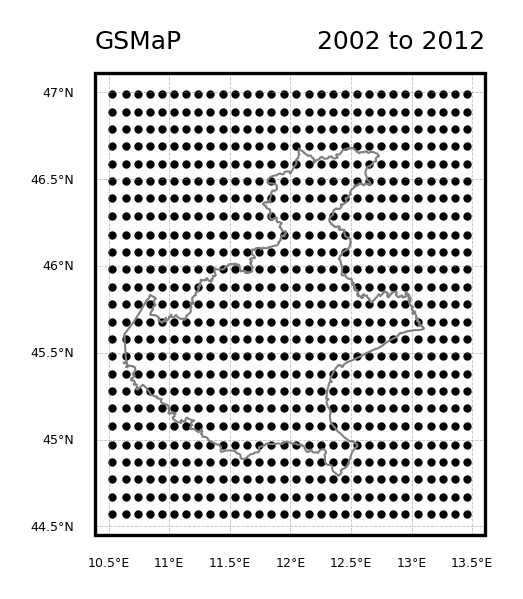

In [ ]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
# ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d_ref, lat2d_ref, s=1, c='k')
# ax1.scatter(lon_ref[9], lat_ref[3], s=1, c='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title(product,fontsize=6,loc='left')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=6,loc='right')

In [ ]:
def downscale_clear(DATA_3h,la,lo,param):

    lat_c = lat_ref[la]
    lon_c = lon_ref[lo]

    Tr = np.array([5, 10, 20, 50, 100, 200])

    box_3h = DOWN_raw.create_box_v2(DATA_3h, lat_c, lon_c, param['npix'])

    all_nan_mask = box_3h.isnull().all(dim='time')
    num_all_nan_pixels = all_nan_mask.sum().item()

    if num_all_nan_pixels == 0:
        print(f'Ignore: {la}, {lo}')

    # all_nan_mask = box_3h.isnull().all(dim='time')
    # num_all_nan_pixels = all_nan_mask.sum().item()
    # total_pixels = all_nan_mask.size
    # nan_ratio = num_all_nan_pixels / total_pixels
    # if nan_ratio < 0.5:

        downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0, 
                                    cor_method=param['corr_method'], toll=toll,
                                    acf=param['acf'], save_yearly=True,
                                    maxmiss=40, clat=lat_c, clon=lon_c,
                                    opt_method=param['opt_method'], plot=False)

    else:
        downres = {}

    return downres

In [ ]:
PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
time_vector_dt = pd.to_datetime(PRE_data_T['PRE']['time'].values)
DATA_3h = xr.DataArray(PRE_data_T['PRE'],  coords={
                            'lon':PRE_data_T['lon'].values, 
                            'lat':PRE_data_T['lat'].values, 
                            'time':time_vector_dt},
                            dims=('lon', 'lat', 'time'))

# Becarful, only for test in GSMaP
# In DOWN_out was add _div2
DATA_3h = DATA_3h / 2

ACF: mar


Text(1.0, 1.0, '2002 to 2012')

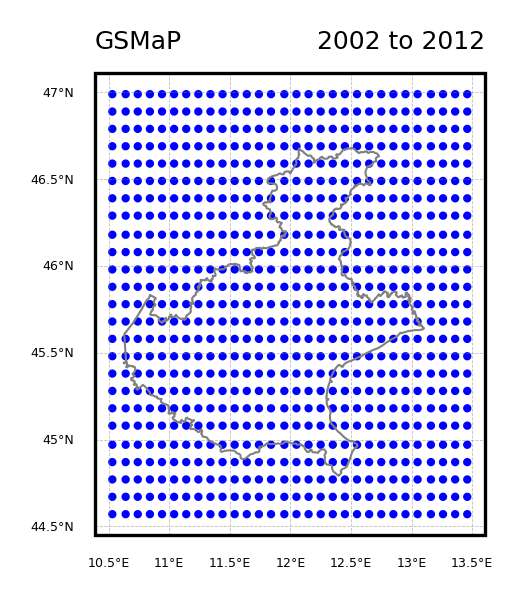

In [ ]:
def colors_ignore(DATA_3h,la,lo,param):
    c_ignore = []
    lat_c = lat_ref[la]
    lon_c = lon_ref[lo]
    box_3h = DOWN_raw.create_box_v2(DATA_3h, lat_c, lon_c, param['npix'])
    all_nan_mask = box_3h.isnull().all(dim='time')
    has_fully_nan_series = all_nan_mask.any()
    if has_fully_nan_series == True:
        c_ignore.append('r')
    else:
        c_ignore.append('b')
    return c_ignore

print(f'ACF: {param['acf']}')

def compute_for_point(args):
    DATA_3h, la, lo, param = args
    return colors_ignore(DATA_3h,la,lo,param)

with Pool(processes=27) as pool:
    c_results = pool.map(compute_for_point, [(DATA_3h,la,lo,param) for la in range(len(lat_ref)) for lo in range(len(lon_ref))])
c_results = [item[0] for item in c_results]

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')
# ax1.scatter(lon2d, lat2d, s=1, c='grey')
ax1.scatter(lon2d_ref, lat2d_ref, s=1, c=c_results)
# ax1.scatter(lon_ref[6], lat_ref[9], s=1, c='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title(product,fontsize=6,loc='left')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=6,loc='right')

In [ ]:
print(f'ACF: {param['acf']}')

def compute_for_point(args):
    DATA_3h, la, lo, param = args
    return la, lo, downscale_clear(DATA_3h,la,lo,param)

with Pool(processes=27) as pool:
    results = pool.map(compute_for_point, [(DATA_3h,la,lo,param) for la in range(len(lat_ref)) for lo in range(len(lon_ref))])

ACF: mar
Ignore: 0, 0
Downscaling Intermittency
Ignore: 0, 7
Downscaling Intermittency
Ignore: 0, 14
Downscaling Intermittency
Ignore: 0, 21
Downscaling Intermittency
Ignore: 0, 28
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Ignore: 1, 5
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Ignore: 1, 12
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Ignore: 1, 19
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Ignore: 1, 26
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Ignore: 2, 3
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Ignore: 2, 10
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
Downscaling the correlation
Computing the correlation
Ignore: 2, 17
Downscaling Intermittency
Ignore: 2, 24
Downscaling Intermittency
Ignore: 3, 1
Downscaling the correlation
Co

Process ForkPoolWorker-50:
Process ForkPoolWorker-53:
Process ForkPoolWorker-37:
Process ForkPoolWorker-47:
Process ForkPoolWorker-41:
Process ForkPoolWorker-44:
Process ForkPoolWorker-43:
Process ForkPoolWorker-30:
Process ForkPoolWorker-35:
Process ForkPoolWorker-42:
Process ForkPoolWorker-49:
Process ForkPoolWorker-40:
Process ForkPoolWorker-29:
Process ForkPoolWorker-52:
Process ForkPoolWorker-48:
Process ForkPoolWorker-39:
Process ForkPoolWorker-46:
Process ForkPoolWorker-54:
Process ForkPoolWorker-45:
Process ForkPoolWorker-32:
Process ForkPoolWorker-33:
Process ForkPoolWorker-51:
Process ForkPoolWorker-36:
Process ForkPoolWorker-34:
Process ForkPoolWorker-28:
Process ForkPoolWorker-38:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent cal

KeyboardInterrupt: 

In [ ]:
# box_3h = DOWN_raw.create_box_v2(DATA_3h, lat_ref[6], lon_ref[9], param['npix'])
# all_nan_mask = box_3h.isnull().all(dim='time')
# num_all_nan_pixels = all_nan_mask.sum().item()
# total_pixels = all_nan_mask.size
# print(num_all_nan_pixels)

In [ ]:
# Tr = np.array([5, 10, 20, 50, 100, 200])
# downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0, 
#                             cor_method=param['corr_method'], toll=toll,
#                             acf=param['acf'], save_yearly=True,
#                             maxmiss=40, clat=lat_ref[3], clon=lon_ref[1],
#                             opt_method=param['opt_method'], plot=False)

In [ ]:
# xdaily0 = box_3h.resample(time ='24h').sum(dim='time', skipna=False)
# xdaily = xdaily0.dropna(dim='time', how='all')

# lons = box_3h.lon.values
# lats = box_3h.lat.values
# nlon = np.size(lons)
# nlat = np.size(lats)
# dx = np.abs(lons[1] - lons[0])
# if nlon != nlat:
#     print('downscale warning: box sizes are not equal')
# if nlon % 2 == 0:
#     print('downscale warning: at least one box size has even length')
# if (bool(lat_ref[3]) and bool(lon_ref[1]) and lat_ref[3] in lats and lon_ref[1] in lons):
#     clat = lats[np.argmin(np.abs(lat_ref[3] - lats))]
#     clon = lons[np.argmin(np.abs(lon_ref[1] - lons))]
#     # otherwise us the one provided by the
# else:
#     clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
#     clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

# tsc = xdaily.loc[dict(lat = lat_ref[3], lon = lon_ref[1])]
# c_excesses = tsc.values[tsc.values > 1] - 1

In [ ]:
# pwets, xscales, tscales = DOWN_raw.compute_pwet_xr(box_3h, 1,
#                                     cube1size=3, dt=24, tmax=48)

In [ ]:
# tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*1
# tscales = tscales[tscales < 48 + 0.001]
# xscales = np.arange(1, 3+1)

In [ ]:
# def wetfrac(array, thresh):
#         if len(array) == 0:
#             return np.nan
#         else:
#             return np.size(array[array > thresh])/np.size(array)

# def space_time_scales_agregations_v2(box, time_reso, tscales, xscales, npix, thresh):
#     nlon = len(box['lon'].data)
#     nlat = len(box['lat'].data)
#     smax = box.shape[0]
#     Swet_final = []

#     for st in tscales:
#         input_data = box.resample(time='{}h'.format(st)).sum(dim='time', skipna = True)

#         for ix, sx in enumerate(xscales):
#             if sx == 1:
#                 wet_tmp = np.zeros([nlon, nlat])
#                 for i in range(nlon):
#                     for j in range(nlat):
#                         wet_tmp[i,j] = wetfrac(input_data[i,j,:].data, thresh)
#                 Swet_final.append(np.nanmean(wet_tmp))

#             elif sx == smax:
#                 rainfall_tmp = input_data.mean(axis=(0,1))
#                 wet_tmp = wetfrac(rainfall_tmp, thresh)
#                 Swet_final.append(np.nanmean(wet_tmp))

#             elif sx > 1 and sx < smax:
#                 Swet_fraction = []
#                 for i in range(nlon):
#                     for j in range(nlat):
#                         box_tmp = input_data[i:i+sx,j:j+sx,:]
#                         if box_tmp.shape[0] == sx and box_tmp.shape[1] == sx:
#                             wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
#                             Swet_fraction.append(wet_tmp)
#                 # c1 = np.zeros(4)
#                 # c1[0] = wetfrac(input_data[:sx, :sx, :].mean(dim=('lat', 'lon'),
#                 #                 skipna=False).dropna(dim='time', how='any'),
#                 #                 thresh)
#                 # c1[1] = wetfrac(input_data[-sx:, :sx, :].mean(dim=('lat', 'lon'),
#                 #                 skipna=False).dropna(dim='time', how='any'),
#                 #                 thresh)
#                 # c1[2] = wetfrac(input_data[:sx, :sx, :].mean(dim=('lat', 'lon'),
#                 #                 skipna=False).dropna(dim='time', how='any'),
#                 #                 thresh)
#                 # c1[3] = wetfrac(input_data[-sx:, :sx, :].mean(dim=('lat', 'lon'),
#                 #                 skipna=False).dropna(dim='time', how='any'),
#                 #                 thresh)
#                 # Swet_fraction.append(np.mean(c1))

#                 Swet_final.append(np.nanmean(Swet_fraction))

#     WET_MATRIX = np.reshape(Swet_final,(len(tscales),npix))
    
#     return WET_MATRIX

In [ ]:
# pwets = space_time_scales_agregations_v2(box_3h, time_reso, tscales, xscales, 3, 1)

In [ ]:
# Taylor = DOWN_raw.Taylor_beta(pwets, xscales, tscales, L1=param['L1'], target_x=0, target_t=24,
#                     origin_x=param['origin_x'], origin_t=24, ninterp = 1000, plot=False)

In [ ]:
# taylor = DOWN_raw.downscale_pwet(box_3h, thresh=1, dt=param['dt'], L1=param['L1'],
#                     target_x=param['L0'], target_t=24,
#                     origin_x=param['L1'], origin_t=24, ninterp=1000, plot=False)

In [ ]:
# nlon = len(box_3h['lon'].data)
# nlat = len(box_3h['lat'].data)
# smax = box_3h.shape[0]
# Swet_final = []

# def wetfrac(array, thresh):
#     if len(array) == 0:
#         return np.nan
#     else:
#         return np.size(array[array > thresh])/np.size(array)

# for st in tscales:
#     # if time_reso == '3h':
#     input_data = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)
#     # elif time_reso == '1dy':
#     #     input_data = box.resample(time='{}d'.format(st)).sum(dim='time', skipna = False)

#     for ix, sx in enumerate(xscales):
#         if sx == 1:
#             wet_tmp = np.zeros([nlon, nlat])
#             for i in range(nlon):
#                 for j in range(nlat):
#                     wet_tmp[i,j] = wetfrac(input_data[i,j,:].data, 1)
#             Swet_final.append(np.nanmean(wet_tmp))

#         elif sx == smax:
#             rainfall_tmp = input_data.mean(axis=(0,1))
#             wet_tmp = wetfrac(rainfall_tmp, 1)
#             Swet_final.append(np.nanmean(wet_tmp))

#         elif sx > 1 and sx < smax:
#             Swet_fraction = []
#             c1 = np.zeros(4)
#             c1[0] = wetfrac(input_data[:sx, :sx, :].mean(dim=('lat', 'lon'),
#                             skipna=True).dropna(dim='time', how='all'),
#                             1)
#             c1[1] = wetfrac(input_data[-sx:, :sx, :].mean(dim=('lat', 'lon'),
#                             skipna=True).dropna(dim='time', how='all'),
#                             1)
#             c1[2] = wetfrac(input_data[:sx, :sx, :].mean(dim=('lat', 'lon'),
#                             skipna=True).dropna(dim='time', how='all'),
#                             1)
#             c1[3] = wetfrac(input_data[-sx:, :sx, :].mean(dim=('lat', 'lon'),
#                             skipna=True).dropna(dim='time', how='all'),
#                             1)
#             Swet_fraction.append(np.mean(c1))

#             Swet_final.append(np.nanmean(Swet_fraction))

# WET_MATRIX = np.reshape(Swet_final,(len(tscales),3))

In [ ]:
# wetfrac(input_data[:sx, :sx, :].mean(dim=('lat', 'lon'),
#                             skipna=True).dropna(dim='time', how='all'),
#                             1)

In [ ]:
# tmp_serie = input_data[-sx:, :sx, :].mean(dim=('lat', 'lon'),skipna=True).dropna(dim='time', how='all')

In [ ]:
# all_nan_mask = box_3htmp.isnull().all(dim='time')
# num_all_nan_pixels = all_nan_mask.sum().item()  # cuántos son True
# total_pixels = all_nan_mask.size
# nan_ratio = num_all_nan_pixels / total_pixels
# num_all_nan_pixels, nan_ratio

In [ ]:
Tr = np.array([5, 10, 20, 50, 100, 200])

shape = (len(lat_ref), len(lon_ref))

NYs = np.full([years_num, *shape], np.nan)
CYs = np.full([years_num, *shape], np.nan)
WYs = np.full([years_num, *shape], np.nan)

NYd = np.full([years_num, *shape], np.nan)
CYd = np.full([years_num, *shape], np.nan)
WYd = np.full([years_num, *shape], np.nan)

Mev_d = np.zeros((len(Tr), *shape))
Mev_s = np.zeros((len(Tr), *shape))

BETA = np.zeros([len(lat_ref), len(lon_ref)])
GAMMA = np.zeros([len(lat_ref), len(lon_ref)])

FUNVAL = np.zeros([len(lat_ref), len(lon_ref)])

for la, lo, downres in results:
    
    if len(downres) == 0:

        NYs[:, la, lo] = [np.nan]*years_num
        CYs[:, la, lo] = [np.nan]*years_num
        WYs[:, la, lo] = [np.nan]*years_num
        
        NYd[:, la, lo] = [np.nan]*years_num
        CYd[:, la, lo] = [np.nan]*years_num
        WYd[:, la, lo] = [np.nan]*years_num
        
        Mev_d[:, la, lo] = [np.nan]*len(Tr)
        Mev_s[:, la, lo] = [np.nan]*len(Tr)
        
        BETA[la, lo] = np.nan
        GAMMA[la, lo] = np.nan
        
        FUNVAL[la,lo] = np.nan
    
    else:
    
        available_years = downres['YEARS'].astype(int) 
        indices = np.searchsorted(full_years, available_years)
        
        NYs[indices, la, lo] = downres['NYs']
        CYs[indices, la, lo] = downres['CYs']
        WYs[indices, la, lo] = downres['WYs']
        
        NYd[indices, la, lo] = downres['NYd']
        CYd[indices, la, lo] = downres['CYd']
        WYd[indices, la, lo] = downres['WYd']
        
        Mev_d[:, la, lo] = downres['mev_d']
        Mev_s[:, la, lo] = downres['mev_s']
        
        BETA[la, lo] = downres['beta']
        GAMMA[la, lo] = downres['gam_d']
        
        FUNVAL[la,lo] = downres['corr_down_funval']

In [ ]:
DOWN_xr = xr.Dataset(data_vars={
                    "NYs": (("year","lat","lon"), NYs),
                    "CYs": (("year","lat","lon"), CYs),
                    "WYs": (("year","lat","lon"), WYs),
                    "Mev_s": (("Tr","lat","lon"), Mev_s),
                    "NYd": (("year","lat","lon"), NYd),
                    "CYd": (("year","lat","lon"), CYd),
                    "WYd": (("year","lat","lon"), WYd),
                    "Mev_d": (("Tr","lat","lon"), Mev_d),
                    "BETA": (("lat","lon"), BETA),
                    "GAMMA": (("lat","lon"), GAMMA),
                    "FUNVAL": (("lat","lon"), FUNVAL)
                    },
    coords={'Year':full_years,'Tr':Tr,'lat': lat_ref, 'lon': lon_ref},
    attrs=dict(description=f"Downscaling for {product} in the {area} area bounded by longitudes {lon_min} to {lon_max} and latitudes {lat_min} to {lat_max}, using '{param['acf']}' as the acf function, '{param['thresh']} mm' threshold, '{param['corr_method']}' correlation, optimization method '{param['opt_method']}', toll equal '{toll}' and box size '{NEIBHR}x{NEIBHR}'."))

DOWN_xr.NYs.attrs["units"] = "day"
DOWN_xr.NYs.attrs["long_name"] = "Number of wet days"
DOWN_xr.NYs.attrs["origname"] = "wet days"

DOWN_xr.CYs.attrs["units"] = "dimensionless"
DOWN_xr.CYs.attrs["long_name"] = "Weibull scale parameter"
DOWN_xr.CYs.attrs["origname"] = "scale"

DOWN_xr.WYs.attrs["units"] = "dimensionless"
DOWN_xr.WYs.attrs["long_name"] = "Weibull shape parameter"
DOWN_xr.WYs.attrs["origname"] = "shape"

DOWN_xr.Mev_s.attrs["units"] = "mm/day"
DOWN_xr.Mev_s.attrs["long_name"] = "Satellite Maximum Quantiles"
DOWN_xr.Mev_s.attrs["origname"] = "Satellite quantiles"

DOWN_xr.NYd.attrs["units"] = "day"
DOWN_xr.NYd.attrs["long_name"] = "Downscale Number of wet days"
DOWN_xr.NYd.attrs["origname"] = "down wet days"

DOWN_xr.CYd.attrs["units"] = "dimensionless"
DOWN_xr.CYd.attrs["long_name"] = "Downscale Weibull scale parameter"
DOWN_xr.CYd.attrs["origname"] = "down scale"

DOWN_xr.WYd.attrs["units"] = "dimensionless"
DOWN_xr.WYd.attrs["long_name"] = "Downscale Weibull shape parameter"
DOWN_xr.WYd.attrs["origname"] = "down shape"

DOWN_xr.Mev_d.attrs["units"] = "mm/day"
DOWN_xr.Mev_d.attrs["long_name"] = "Downscaling Maximum Quantiles"
DOWN_xr.Mev_d.attrs["origname"] = "Downscaling quantiles"

DOWN_xr.BETA.attrs["units"] = "dimensionless"
DOWN_xr.BETA.attrs["long_name"] = "Itermittency function between two generic scales"
DOWN_xr.BETA.attrs["origname"] = "beta"

DOWN_xr.GAMMA.attrs["units"] = "dimensionless"
DOWN_xr.GAMMA.attrs["long_name"] = "variance function between two generic scales"
DOWN_xr.GAMMA.attrs["origname"] = "gamma"

DOWN_xr.FUNVAL.attrs["units"] = "dimensionless"
DOWN_xr.FUNVAL.attrs["long_name"] = "minimum error achieved by the optimization"
DOWN_xr.FUNVAL.attrs["origname"] = "funval"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [ ]:
DOWN_out = os.path.join(dir_base,'Satellite','5_DOWN',f'{area}_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{param['npix']}_thr_{param['thresh']}_acf_{param['acf']}_{param['opt_method']}_{param['corr_method']}_div2.nc')
print(f'Export PRE data to {DOWN_out}')
DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/5_DOWN/COAST_DOWN_CHIRPS_1dy_2002_2012_npix_2_thr_1_acf_mar_genetic_pearson.nc


In [ ]:
playsound("../sound/HOMER_DOH.mp3")